In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Style Transfer"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
%matplotlib inline

In [0]:
def computeContentCost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C,(n_H * n_W,n_C))
    a_G_unrolled = tf.reshape(a_G,(n_H * n_W,n_C))
    
    J_content = 1/(4*n_H*n_W*n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled , a_G_unrolled)))
    
    return J_content

In [0]:
def gramMatrix(A):
    
    GA = tf.matmul(A,tf.transpose(A))
    
    return GA

In [0]:
def computeLayerStyleCost(a_S, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S,(n_H*n_W,n_C))
    a_G = tf.reshape(a_G,(n_H*n_W,n_C))

    GS = gramMatrix(tf.transpose(a_S))
    GG = gramMatrix(tf.transpose(a_G))

    J_style_layer = 1/(4 * (n_C **2) * ((n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS,GG))) 
        
    return J_style_layer

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
def computeStyleCost(model, STYLE_LAYERS):
    
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = computeLayerStyleCost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [0]:
def totalCost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [0]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    
    generated_image = sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        
        generated_image = generated_image = sess.run(model["input"])
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


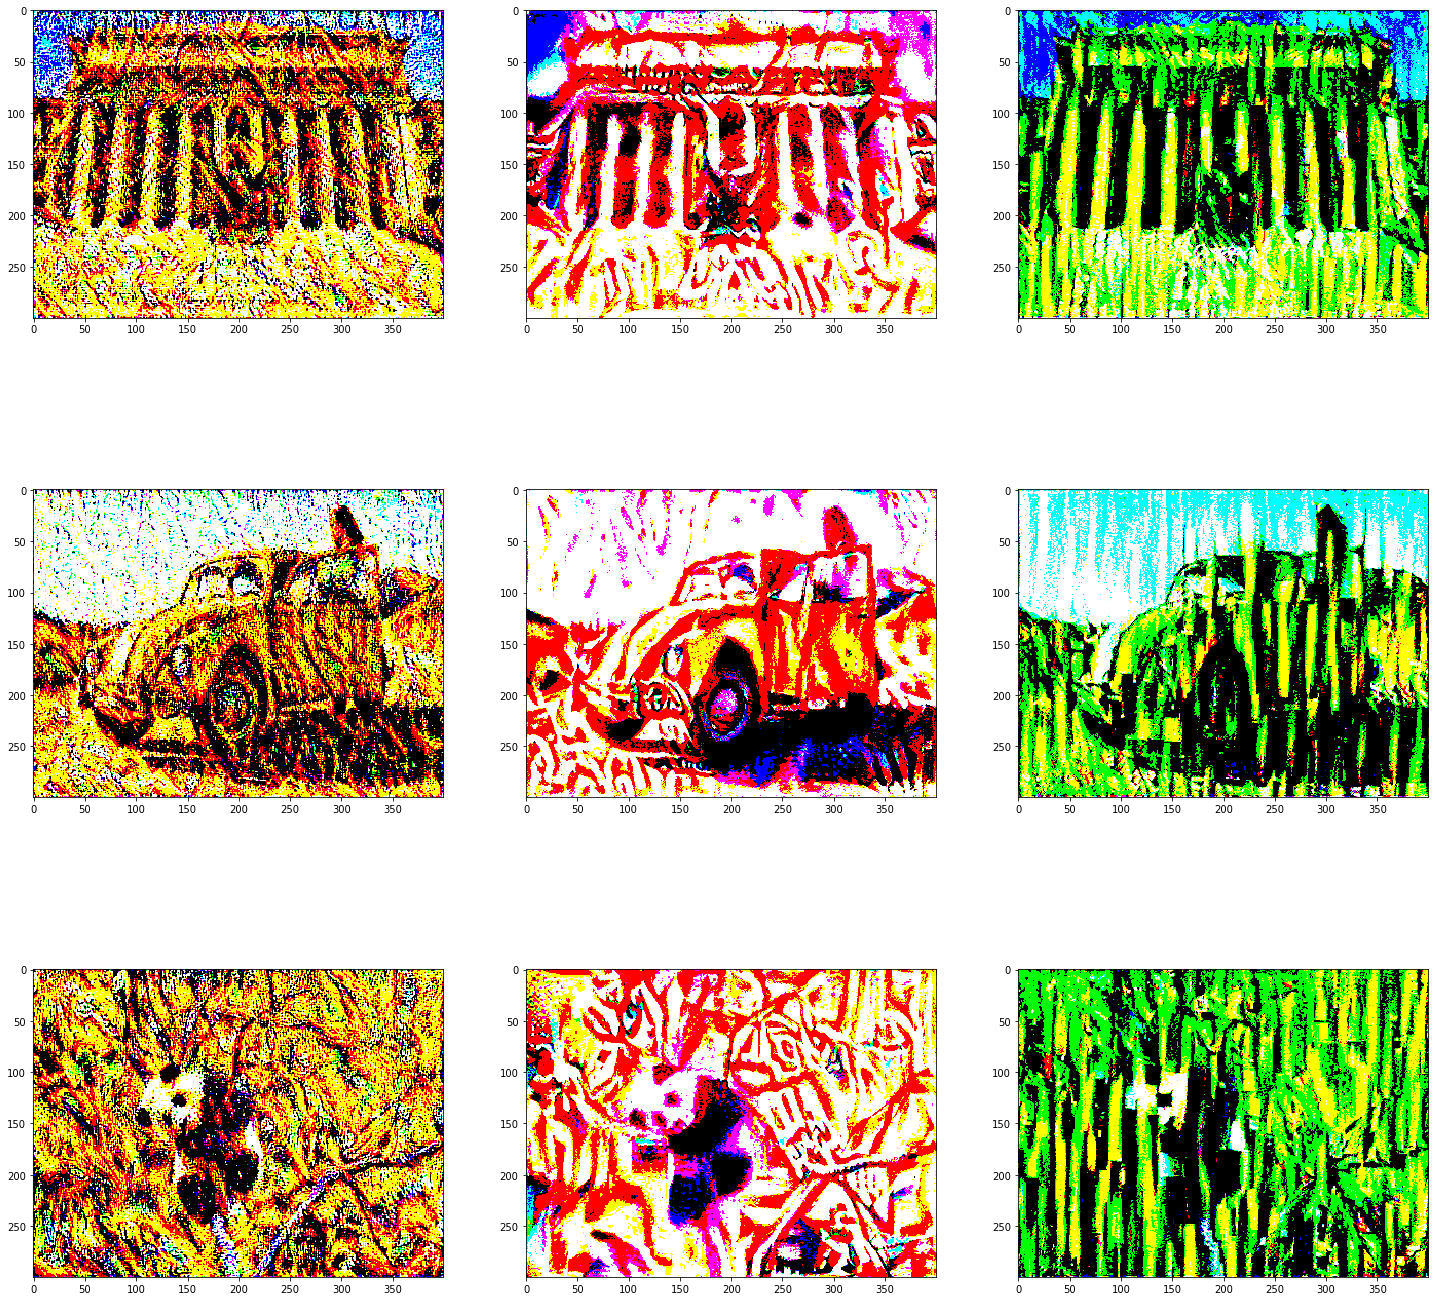

In [12]:
import warnings
warnings.simplefilter('ignore')

fig, axes = plt.subplots(3, 3, figsize = (25, 25))

row = 0
for content_name in os.listdir('images/Content'):
  col = 0
  for style_name in os.listdir('images/Style'):
    tf.reset_default_graph()

    sess = tf.InteractiveSession()
    content_image = plt.imread('images/Content' + os.sep + content_name)
    content_image = reshape_and_normalize_image(content_image)

    style_image = plt.imread("images/Style" + os.sep + style_name)
    style_image = reshape_and_normalize_image(style_image)

    generated_image = generate_noise_image(content_image)

    model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

    sess.run(model['input'].assign(content_image))
    out = model['conv4_2']
    a_C = sess.run(out)
    a_G = out
    J_content = computeContentCost(a_C, a_G)

    sess.run(model['input'].assign(style_image))
    J_style = computeStyleCost(model, STYLE_LAYERS)

    J = totalCost(J_content,J_style, 1, 1000)

    optimizer = tf.train.AdamOptimizer(0.5)
    train_step = optimizer.minimize(J)

    ans = model_nn(sess, generated_image, 2000)
    axes[row, col].imshow(ans[0])
    col += 1
  row += 1